In [1]:
import os
import sys
from functools import partial
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
sys.path.append(base_path)

base_path: /root/sr-press


In [2]:
import express.config as config
from express.databases import SQLiteDatabase
from express.datasets import PressingDataset
from express.simulates import expressXGBoostComponent, exPressPytorchComponent
from express.utils import add_names
from express.visualization import plot_action

## Component Prediction

In [3]:
# Configuration
model = "soccermap" # xgboost or soccermap
trial = 1 # 15

path = Path(base_path) / "stores" / "model" / model / f"{trial:03d}" / "component.pkl"
with path.open(mode="rb") as file:
    component = pickle.load(file)
component

In [4]:
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")
test_db = SQLiteDatabase(TEST_DB_PATH)
dataset_test = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "test"))

component.test(dataset_test)

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /root/sr-press/stores/model/soccermap/001/val_loss= 0.58.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
Loaded model weights from the checkpoint at /root/sr-press/stores/model/soccermap/001/val_loss= 0.58.ckpt


Predicting: 0it [00:00, ?it/s]

{'precision': 0.2964503605102607,
 'recall': 0.9967365967365968,
 'f1': 0.45698407609276476,
 'log_loss': 0.60564128174463,
 'brier': 0.2076243261712386,
 'roc_auc': 0.538586304368564}

In [5]:
preds = component.predict(dataset_test)
preds

Restoring states from the checkpoint path at /root/sr-press/stores/model/soccermap/001/val_loss= 0.58.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
Loaded model weights from the checkpoint at /root/sr-press/stores/model/soccermap/001/val_loss= 0.58.ckpt


Predicting: 0it [00:00, ?it/s]

game_id  action_id
3857254  4            0.225243
         14           0.267663
         17           0.336053
         22           0.292123
         34           0.323315
                        ...   
3869685  3013         0.248200
         3020         0.359521
         3031         0.210605
         3041         0.365327
         3045         0.359666
Length: 14504, dtype: float32

<Axes: title={'center': 'pressing & success: 0.29475'}>

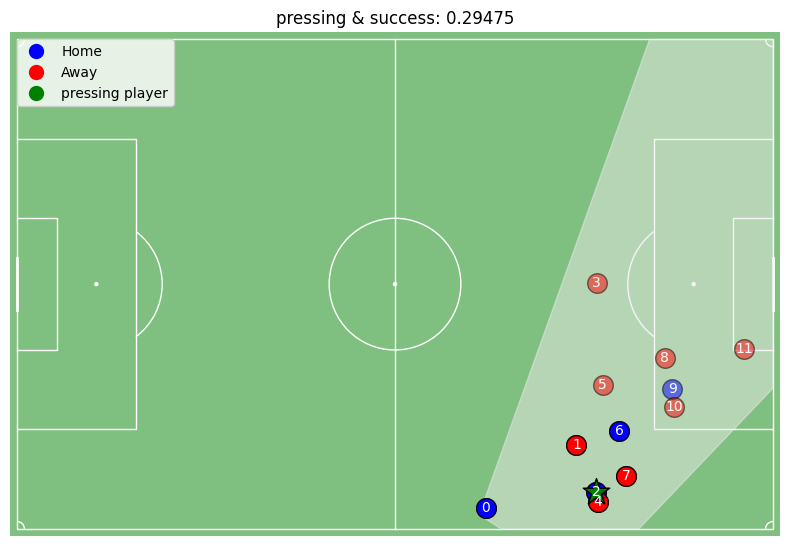

In [6]:
game_id = 3857254
action_id = 90
idx = (game_id, action_id)

home_team_id, away_team_id = test_db.get_home_away_team_id(game_id = game_id)
actions = add_names(test_db.actions(game_id))


plot_action(actions.loc[idx], home_team_id=home_team_id, prob=preds.loc[idx])

## Optimal Pressing Simulation

In [7]:
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")
test_db = SQLiteDatabase(TEST_DB_PATH)
dataset_test = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "test"))

if model == "xgboost":
    test_dataset = PressingDataset(
        path= os.path.join(base_path, "stores", "datasets", "test"),
        xfns=["startlocation", "closest_11_players"],
        yfns=["counterpress"],
        load_cached=True,
        nb_prev_actions=3
    )
    simulater = expressXGBoostComponent(test_db, component, 
                                        xfns= test_dataset.xfns.keys(), nb_prev_actions=3)
elif model == "soccermap":
    test_dataset = PressingDataset(
        path= os.path.join(base_path, "stores", "datasets", "test"),
        xfns=["startlocation", "freeze_frame_360"],
        yfns=["counterpress"],
        load_cached=True,
        nb_prev_actions=3
    )
    simulater = exPressPytorchComponent(test_db, component, 
                                        xfns= test_dataset.xfns.keys(), labels=test_dataset.labels, nb_prev_actions=3)

simulater

In [9]:
player_ids = [6, 9]
freeze_frame_360 = pd.DataFrame(actions.loc[idx]["freeze_frame_360"])

# range: -5m ~ 5m
dx_range = range(-5, 6) 
dy_range = range(-5, 6)
pos_by_players = {}
for player_id in player_ids:
    x, y = freeze_frame_360.loc[player_id, ["x", "y"]]
    pos = [(x + dx, y + dy) for dx in dx_range for dy in dy_range]
    pos_by_players[player_id] = pos

simulated_instances = simulater.simulate(game_id= game_id, action_id=action_id, pos_by_players=pos_by_players)
simulated_instances

Simulating with PyTorch model: 100%|██████████| 14642/14642 [05:59<00:00, 40.78it/s]


 ...]

In [10]:
raw_instance = next((instance for instance in simulated_instances if instance.is_raw), None)
if not raw_instance:
    raise ValueError("No instance with raw set to True found.")

k = 8
sorted_instances = sorted(
    [instance for instance in simulated_instances if not instance.is_raw],
    key=lambda x: x.prob,
    reverse=True
)

instances = [raw_instance] + sorted_instances[:k]
for instance in instances:
    print(f"{instance}: {instance.prob : .3f}")

<express.simulates.SimulatedInstance object at 0x7fca012333d0>:  0.289
<express.simulates.SimulatedInstance object at 0x7fc70b968ca0>:  0.291
<express.simulates.SimulatedInstance object at 0x7fc70b95c370>:  0.291
<express.simulates.SimulatedInstance object at 0x7fc70b9b6f40>:  0.291
<express.simulates.SimulatedInstance object at 0x7fc70b95ceb0>:  0.291
<express.simulates.SimulatedInstance object at 0x7fc70b98ed90>:  0.291
<express.simulates.SimulatedInstance object at 0x7fc70b968160>:  0.291
<express.simulates.SimulatedInstance object at 0x7fc70b9763a0>:  0.291
<express.simulates.SimulatedInstance object at 0x7fc70b945a30>:  0.291


In [11]:
def _fix_direction_of_play(actions: pd.DataFrame, home_team_id: int) -> pd.DataFrame:
    away_idx = (actions.team_id != home_team_id).values
    for col in ["start_x", "end_x"]:
        actions.loc[away_idx, col] = config.field_length - actions[away_idx][col].values
    for col in ["start_y", "end_y"]:
        actions.loc[away_idx, col] = config.field_width - actions[away_idx][col].values

    return actions

def _sb_freeze_frame_to_spadl(freeze_frame,invert: bool = False):
    if not isinstance(freeze_frame, list):
        return None
    freezedf = pd.DataFrame(
        {
            "teammate": e["teammate"],
            "actor": e["actor"],
            "keeper": e["keeper"],
            "x": e["x"],
            "y": e["y"],
        }
        for e in freeze_frame
    )

    if invert:
        freezedf["x"] = config.field_length - freezedf["x"].values
        freezedf["y"] = config.field_width - freezedf["y"].values
    return list(freezedf.to_dict("records"))

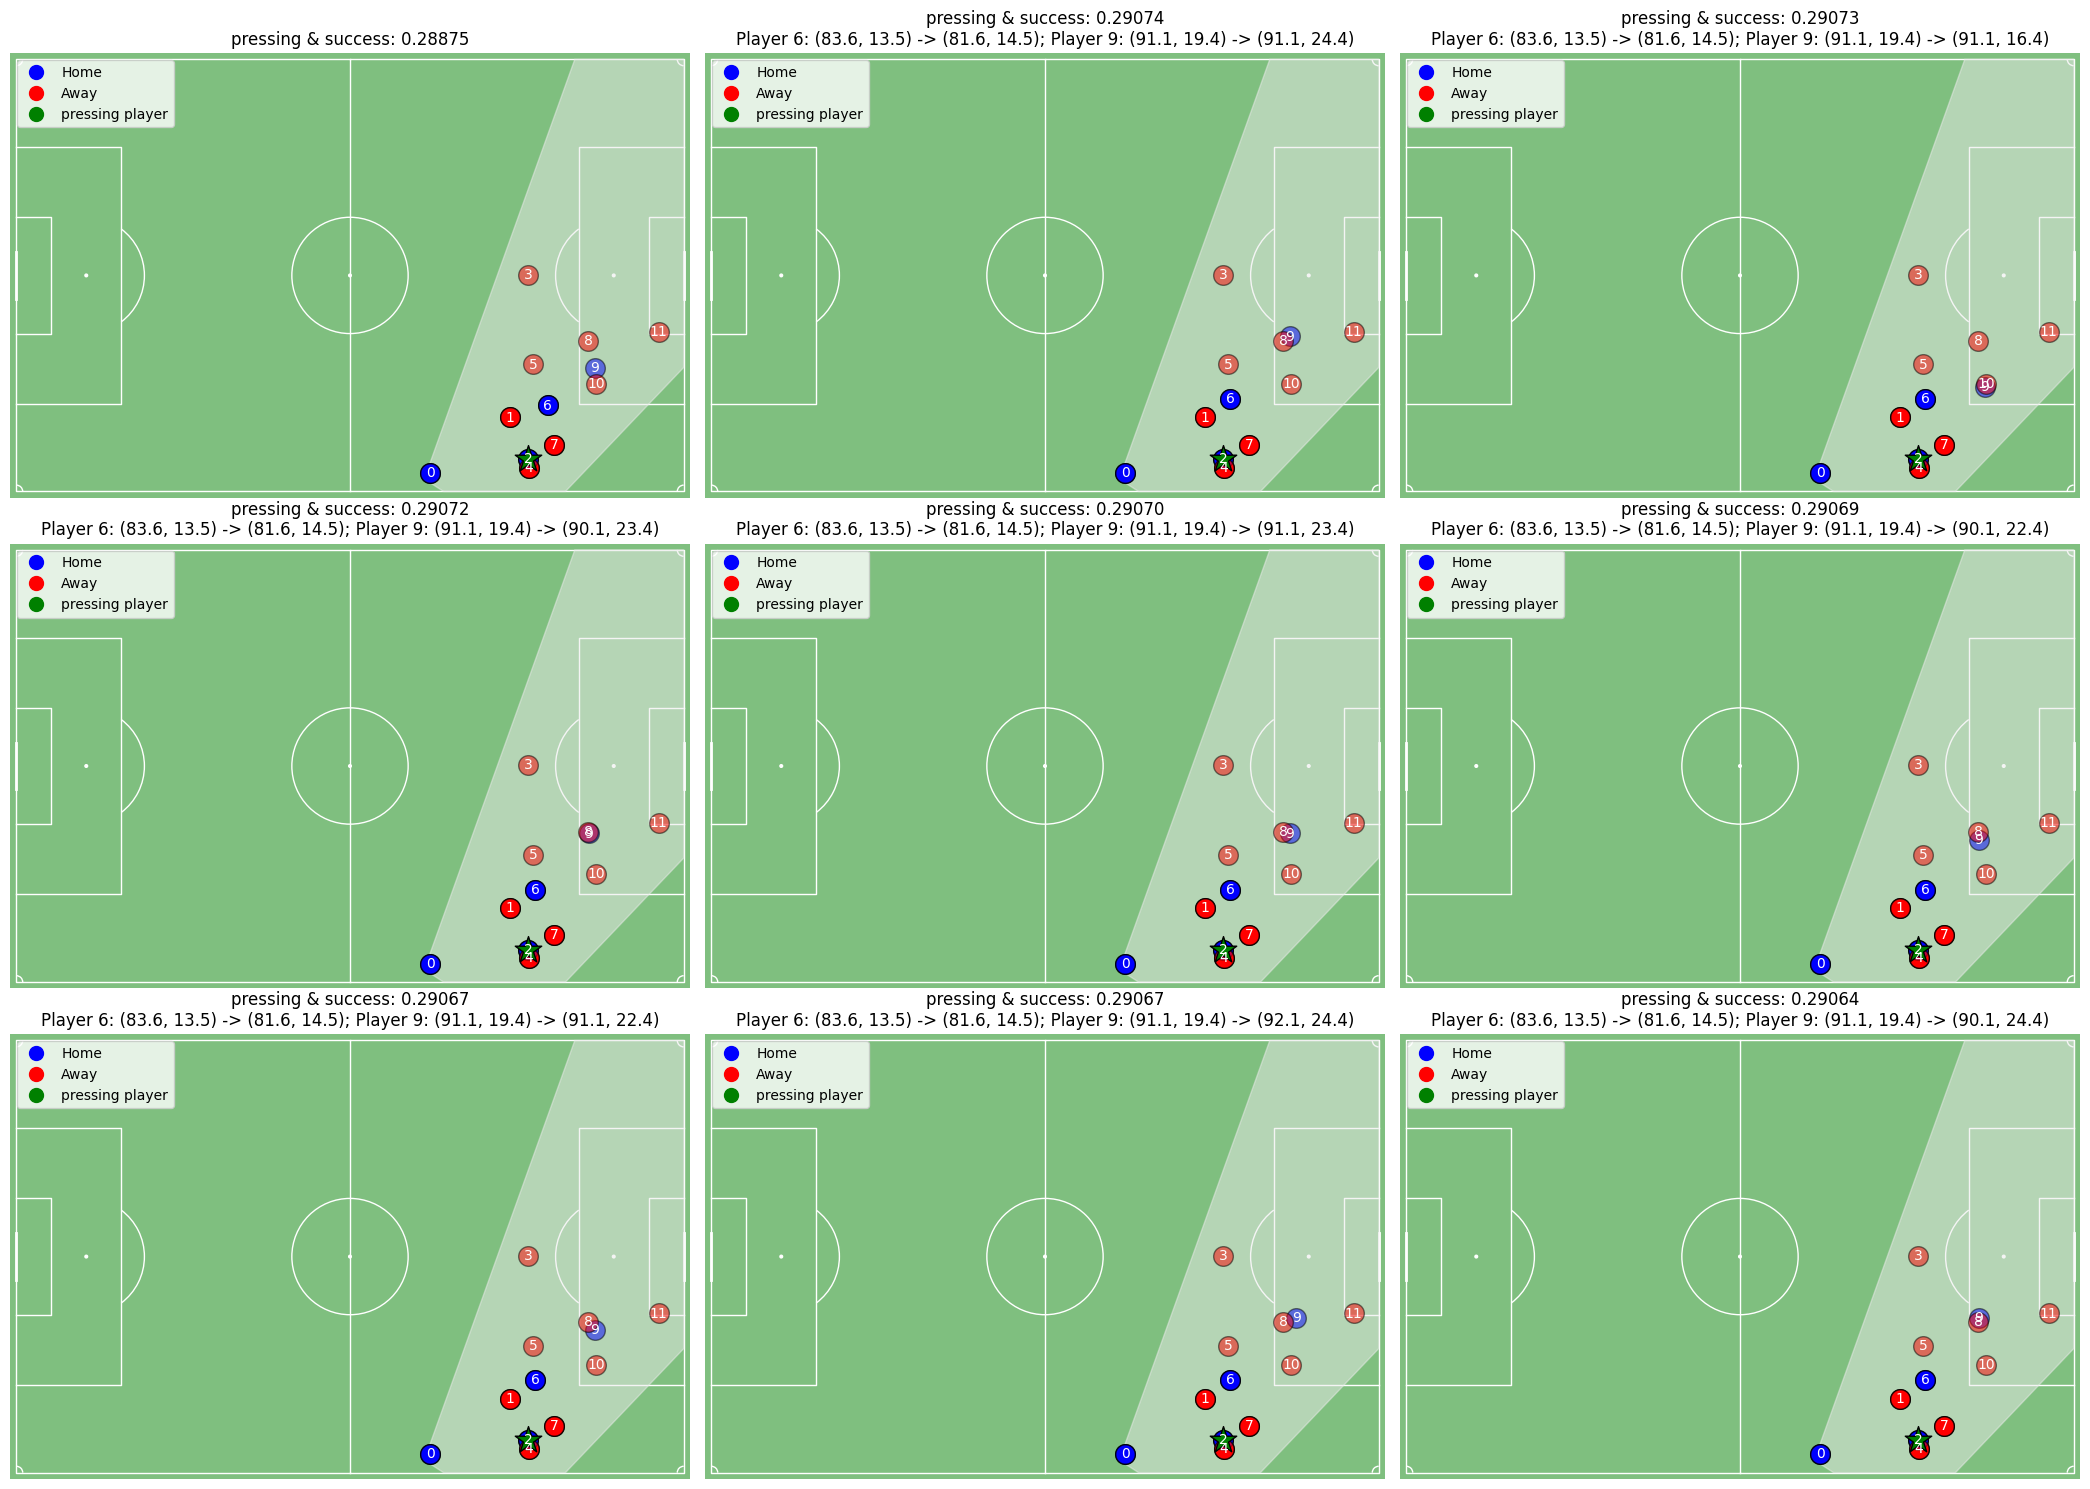

In [12]:
cols = int(k ** 0.5) + 1  
rows = (k + cols - 1) // cols  

fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows))
axes = axes.flatten()

for i, instance in enumerate(instances):
    #All plays are played from left to right, so convert away back to right
    action = instance.state 

    # Coordinates were converted to left-to-right during prediction
    # But during visualization, the home team should be left->right and the away team should be right->left
    action = _fix_direction_of_play(action, home_team_id)
    action["freeze_frame_360"] = action.assign(away_idx=(action.team_id != home_team_id)).apply(
        lambda x: _sb_freeze_frame_to_spadl(x.freeze_frame_360, x.away_idx), axis=1
    )
    prob = instance.prob

    plot_action(
        action= action.squeeze(),
        home_team_id=home_team_id,
        prob=prob,
        ax=axes[i]
    )
    
    player_ids = instance.simulated_pos
    if player_ids is not None:
        simulated_position_lst = []

        for id, (simulated_x, simulated_y) in instance.simulated_pos.items():
            raw_x, raw_y = freeze_frame_360.loc[id, ['x', 'y']]
            simulated_pos_str = f"Player {id}: ({raw_x:.1f}, {raw_y:.1f}) -> ({simulated_x:.1f}, {simulated_y:.1f})"
            simulated_position_lst.append(simulated_pos_str)

        positions_info = '; '.join(simulated_position_lst)
        title_prefix = f'{action["type_name"].values[0]} & {action["result_name"].values[0]}: {prob:.5f}'
        axes[i].set_title(f"{title_prefix}\n{positions_info}")

plt.tight_layout()
plt.show()